# Dynamic Analysis

In [1]:
!date

Thu 20 Apr 2023 11:49:40 AM UTC


### Selected Windows API sequence

The example below is a malware called 'Delf'

It md5 is 0c494687e1a01a7e3eefc541f0a91d50.

In [2]:
!wget https://drive.google.com/uc?id=14eCWgQ9etP1QOmZArvpyPJEWVgTQzg_E -O 272mal_newhooklog.zip

--2023-04-20 11:49:40--  https://drive.google.com/uc?id=14eCWgQ9etP1QOmZArvpyPJEWVgTQzg_E
Resolving drive.google.com (drive.google.com)... 142.250.98.139, 142.250.98.138, 142.250.98.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.98.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-38-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s1c13c9ajeapm350q6huvithfr2tar4t/1681991325000/17174434063503717705/*/14eCWgQ9etP1QOmZArvpyPJEWVgTQzg_E?uuid=00395d47-c922-4e39-8fab-5f0ee5281712 [following]
--2023-04-20 11:49:59--  https://doc-0c-38-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s1c13c9ajeapm350q6huvithfr2tar4t/1681991325000/17174434063503717705/*/14eCWgQ9etP1QOmZArvpyPJEWVgTQzg_E?uuid=00395d47-c922-4e39-8fab-5f0ee5281712
Resolving doc-0c-38-docs.googleusercontent.com (doc-0c-38-docs.googleusercontent.com)... 108.177.12.132, 2607:f8b0:400c:c08::84
Connecting to doc-0c

In [3]:
!unzip /content/272mal_newhooklog.zip

Archive:  /content/272mal_newhooklog.zip
   creating: hooklogs/
  inflating: hooklogs/0006dfb19193ff5910b3ffc94a29a7f6_1416.trace.hooklog  
  inflating: hooklogs/0278192ce1aa7f8c4ae746eae73e6475_1484.trace.hooklog  
  inflating: hooklogs/02c27a2e4c215d22fabdfc7b46fd6f20_1536.trace.hooklog  
  inflating: hooklogs/02fbfeafd096088a56f6ffb9_1380.trace.hooklog  
  inflating: hooklogs/03ae42959b733f11a168e268_1264.trace.hooklog  
  inflating: hooklogs/03ae42959b733f11a168e268_1332.trace.hooklog  
  inflating: hooklogs/03c009b451e012002513513a5d7e1b00_1280.trace.hooklog  
  inflating: hooklogs/03c009b451e012002513513a5d7e1b00_604.trace.hooklog  
  inflating: hooklogs/043121379d4a5f0f227d74ef0336428c_1636.trace.hooklog  
  inflating: hooklogs/060c18ffe4b4f8b47c90a2339533d622_1568.trace.hooklog  
  inflating: hooklogs/0776c66dfed69d4ea0b60d1c_1504.trace.hooklog  
  inflating: hooklogs/08261732bfcae9a06c7fd6e6f76b2a81_1100.trace.hooklog  
  inflating: hooklogs/08261732bfcae9a06c7fd6e6f76b2a81_13

In [4]:
!head -21 /content/hooklogs/0006dfb19193ff5910b3ffc94a29a7f6_1416.trace.hooklog

1416 malware.exe
#237690000
LoadLibrary
lpFileName=advapi32.dll
Return=SUCCESS
#238830000
LoadLibrary
lpFileName=kernel32.dll
Return=SUCCESS
#239360000
LoadLibrary
lpFileName=advapi32.dll
Return=SUCCESS
#242610000
RegQueryValue
hKey=HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Control\Session Manager\CriticalSectionTimeout
Return=SUCCESS
#242610000
RegQueryValue
hKey=HKEY_LOCAL_MACHINE\Software\Microsoft\Ole\RWLockResourceTimeOut
result=FAILURE


# Parser

### hooklog (selected WinAPI)

In [44]:
import os

class Hooklog(object):
  filepathname = None #path of the hooklog file
  par = None #the parameter for constructor, default False
  
  digitname = None
  length = None # length of li
  li = None # a list of api call; element example: ('241080000', 'LoadLibrary')

  def __init__(self, filepathname, par = False):
    self.filepathname = filepathname
    self.par = par
    self.li = list()# a list of tick, api, pars e.g. tick: 471880000, api: RegQueryValue, pars: None
    self.length = 0
    
    assert filepathname != ""
    self._parseDigitName()
    self._parseHooklog()
  
  def __len__(self):
    return self.length
  
  def __iter__(self):
    return iter(self.li)
  
  def __str__(self):
    return "class Hooklog: %s, par = %s, len = %d, digit name = %s" % (self.filepathname, self.par, self.length, self.digitname)
  
  def _parseDigitName(self):
    self.digitname = self.filepathname.split('/')[-1][0:6] + '-' + self.filepathname.split('_')[-1].split('.')[0]
    
  def _parseHooklog(self):
    if os.path.isfile(self.filepathname):
      handle = open(self.filepathname, "rb")
      
      while True:
        tick, api, pars = self._getNextPair(handle)#  tick是#後面的數字
        if tick == 0:
          break
        if self.par:
          self.li.append((tick, api, pars))
        else:
          self.li.append((tick, api))
        self.length += 1
      if handle:
        handle.close()
        
      self.li.sort(key = lambda tup: tup[0]) # sort by tick
      
    else:
      print("file not exist!")
      raise
      
  def _getNextPair(self, handle):
    tick = 0
    api = ''
    pars = None
    
    while True:
      line = handle.readline().decode("windows-1252")
      if not line:
        break # eof
      if line[0] == '#': # a new call
        tick = line[1:].strip()#extract call name, and eliminate 開頭和結尾的空白字元
        api = handle.readline().decode("windows-1252").strip() # next line e.g.LoadLibrary or RegEnumValue
        api = api[1:] if api[0] == '=' else api # remove '='
        
        if self.par == True:
          pars = self._getParValue(api, handle)
        break
      else:
        continue
    return tick, api, pars
  
  def _getParValue(self, api, handle):
    firstpar = handle.readline().decode("windows-1252").strip()
    return firstpar
  
  def getAPISet(self, gram = 1):
    _set = set()
    for i in range(self.length - gram + 1):
      key = ''
      for g in range(gram):
        key += self.li[i+g][1] # api
      _set.add(key)
    return _set

In [38]:
# directory walk

import os

hl_list = []
sn_list = [] # short name

for dirPath, dirNames, fileNames in os.walk("/content/hooklogs"):
  for fileName in fileNames:
    filenamepath = os.path.join(dirPath, fileName)
    try:
      hl = Hooklog(filenamepath)#par=False
      hl_list.append(hl)
      sn_list.append(hl.digitname)
    except:
      print("Error:", filenamepath)

In [59]:
# Parameterized when setting par=True
hl_par_list = []
sn_par_list = [] # short name

for dirPath, dirNames, fileNames in os.walk("/content/hooklogs"):
  for fileName in fileNames:
    filenamepath = os.path.join(dirPath, fileName)
    try:
      hl = Hooklog(filenamepath, par=True)#par=True
      hl_par_list.append(hl)
      sn_par_list.append(hl.digitname)
    except:
      print("Error:", filenamepath)

In [16]:
# par = False
# print the first 10 calss
count = 20
for call in hl_list[0]:
  print(call)
  if count <= 1:
    break
  else:
    count -= 1

('225240000', 'LoadLibrary')
('226490000', 'LoadLibrary')
('227340000', 'LoadLibrary')
('230420000', 'RegQueryValue')
('230420000', 'RegQueryValue')
('231120000', 'LoadLibrary')
('232590000', 'CreateFile')
('232880000', 'RegQueryValue')
('232890000', 'RegQueryValue')
('233330000', 'RegCreateKey')
('233430000', 'RegQueryValue')
('233770000', 'LoadLibrary')
('234210000', 'LoadLibrary')
('235460000', 'RegQueryValue')
('238020000', 'RegQueryValue')
('238040000', 'RegQueryValue')
('238090000', 'LoadLibrary')
('240980000', 'RegQueryValue')
('241080000', 'LoadLibrary')
('241200000', 'CreateFile')


# Malware Variants in a family



### Encode a sequence: onehot


In [45]:
APISet = set()
for hl in hl_list:
  APISet = APISet.union(hl.getAPISet(gram = 1))
APISet_li = list(APISet)

In [47]:
APIDict = {i:api for i,api in list(enumerate(APISet_li))}
APIDict.update( {api:i for i,api in list(enumerate(APISet_li))} )
APIDict

{0: 'CreateFile',
 1: 'OpenProcess',
 2: 'CopyFile',
 3: 'LoadLibrary',
 4: 'RegDeleteKey',
 5: 'CreateProcess',
 6: 'CreateProcessInternal',
 7: 'RegCreateKey',
 8: 'RegSetValue',
 9: 'RegQueryValue',
 10: 'DeleteFile',
 11: 'ExitProcess',
 12: 'L',
 13: 'RegEnumValue',
 'CreateFile': 0,
 'OpenProcess': 1,
 'CopyFile': 2,
 'LoadLibrary': 3,
 'RegDeleteKey': 4,
 'CreateProcess': 5,
 'CreateProcessInternal': 6,
 'RegCreateKey': 7,
 'RegSetValue': 8,
 'RegQueryValue': 9,
 'DeleteFile': 10,
 'ExitProcess': 11,
 'L': 12,
 'RegEnumValue': 13}

In [49]:
onehot_hl_li = []

for hl in hl_list:
  onehot_api_li = [0]*14
  for t, api in hl:
    onehot_api_li[APIDict[api]] = 1
  onehot_hl_li.append(onehot_api_li)

print(len(onehot_hl_li))

419


In [50]:
import pandas as pd
import numpy as np

df = pd.DataFrame(onehot_hl_li, columns=APISet_li, index=sn_list)
df

,CreateFile,OpenProcess,CopyFile,LoadLibrary,RegDeleteKey,CreateProcess,CreateProcessInternal,RegCreateKey,RegSetValue,RegQueryValue,DeleteFile,ExitProcess,L,RegEnumValue
257700-1260,1,0,0,1,1,0,0,1,1,1,0,0,0,1
2272d0-1472,1,0,0,1,0,1,1,1,0,1,0,0,0,0
8523f5-1412,0,0,0,1,0,1,1,0,0,1,0,1,0,0
79a958-1360,1,0,1,1,0,1,1,1,1,1,1,1,0,0
516911-1268,1,0,0,1,0,0,0,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90bc59-1072,1,0,0,1,1,0,0,1,1,1,0,0,0,1
5170d6-1440,1,0,0,1,0,0,0,1,0,1,0,0,0,0
940f7e-316,1,1,0,1,1,0,0,1,1,1,1,0,0,1
1037b8-1364,1,0,0,1,0,0,0,1,0,1,1,0,0,0


In [51]:
df.sum()

CreateFile               402
OpenProcess               60
CopyFile                  23
LoadLibrary              406
RegDeleteKey             136
CreateProcess            127
CreateProcessInternal    140
RegCreateKey             322
RegSetValue              222
RegQueryValue            415
DeleteFile               122
ExitProcess              105
L                          1
RegEnumValue             160
dtype: int64

1. One-hot
2. Multi-gram
3. Frequency

# PCA

explained variance ratio: [0.35290373 0.24362791]


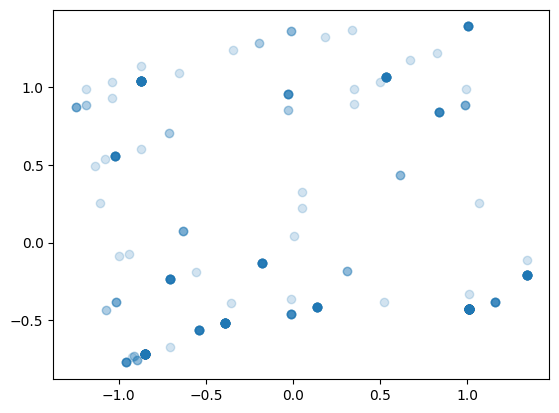

In [52]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = np.array(onehot_hl_li)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.2)
plt.show()

# UPGMA

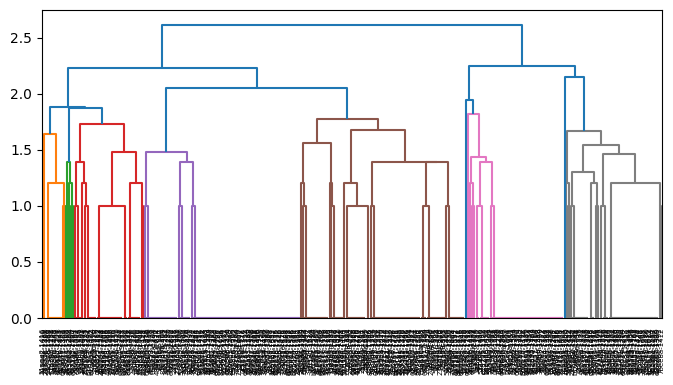

In [53]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(8,4))

X = np.array(onehot_hl_li)
Z = sch.linkage(X, method = 'weighted') # X is a 2d array of observation vectors.
dn = sch.dendrogram(Z, labels = sn_list, orientation = 'top')

plt.show()

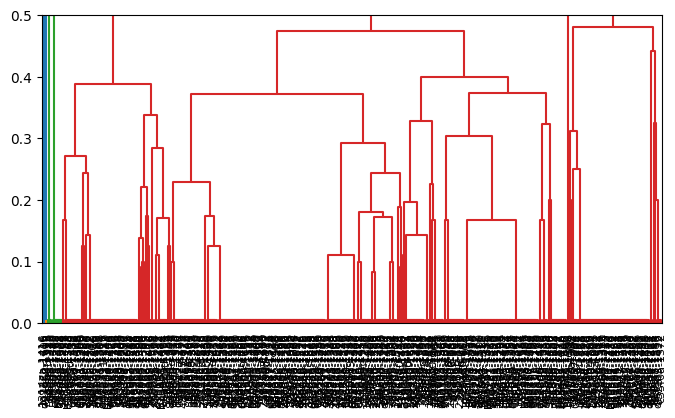

In [54]:
import scipy
import sklearn.metrics as sm 

plt.figure(figsize=(8,4))

X = np.array(onehot_hl_li)

# the double loop can be improved, how?
matrix = list()
for i in sn_list:
  li = list()
  for j in sn_list:
    i_ser = df.loc[i]
    j_ser = df.loc[j]

    _inter_ser = i_ser & j_ser
    _union_ser = i_ser | j_ser
    
    if sum(_union_ser) > 0:
      jaccard = round(sum(_inter_ser)/sum(_union_ser), 4)
      li.append(1.0 - jaccard)
    else:
      li.append(0.0)

  matrix.append(li)
# end of create distance matrix

D = scipy.spatial.distance.squareform(matrix)
Z = sch.linkage(D, method = 'weighted') # X is a 1d condensed distance matrix.
# hack Z
Z = [[z[0], z[1], 0.005 if z[2]==0 else z[2], z[3]] for z in Z]
# end of hack Z
dn = sch.dendrogram(Z, labels = sn_list, orientation = 'top')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90, fontsize=8)
plt.ylim(0.0, 0.5)
plt.show()

# DotMatrix

In [55]:
def createDotMatrix(hl):
  n = len(hl)

  x = hl.li
  y = hl.li

  matched = [[0 for j in range(n)] for i in range(n)]
  for i, t_api_x in enumerate(x):
    for j, t_api_y in enumerate(y):
      if hl.par == True:
        api_x = t_api_x[1] + t_api_x[2]
        api_y = t_api_y[1] + t_api_y[2]
      else:
        api_x = t_api_x[1]
        api_y = t_api_y[1]
      if api_x == api_y:
        matched[j][i] = 1.0

  return matched

In [56]:
hl = hl_list[0]
matched = createDotMatrix(hl)

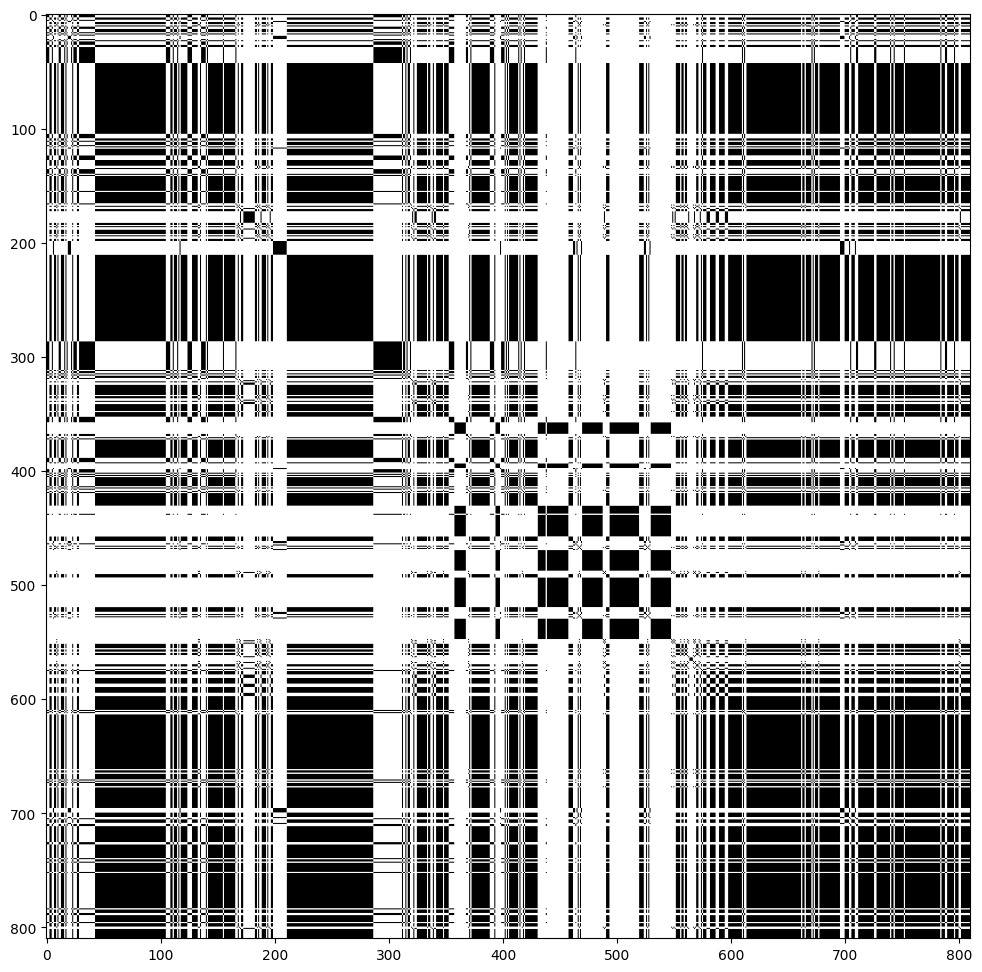

In [57]:
plt.figure(figsize=(12,12))
plt.imshow(matched, cmap='Greys')
plt.show()

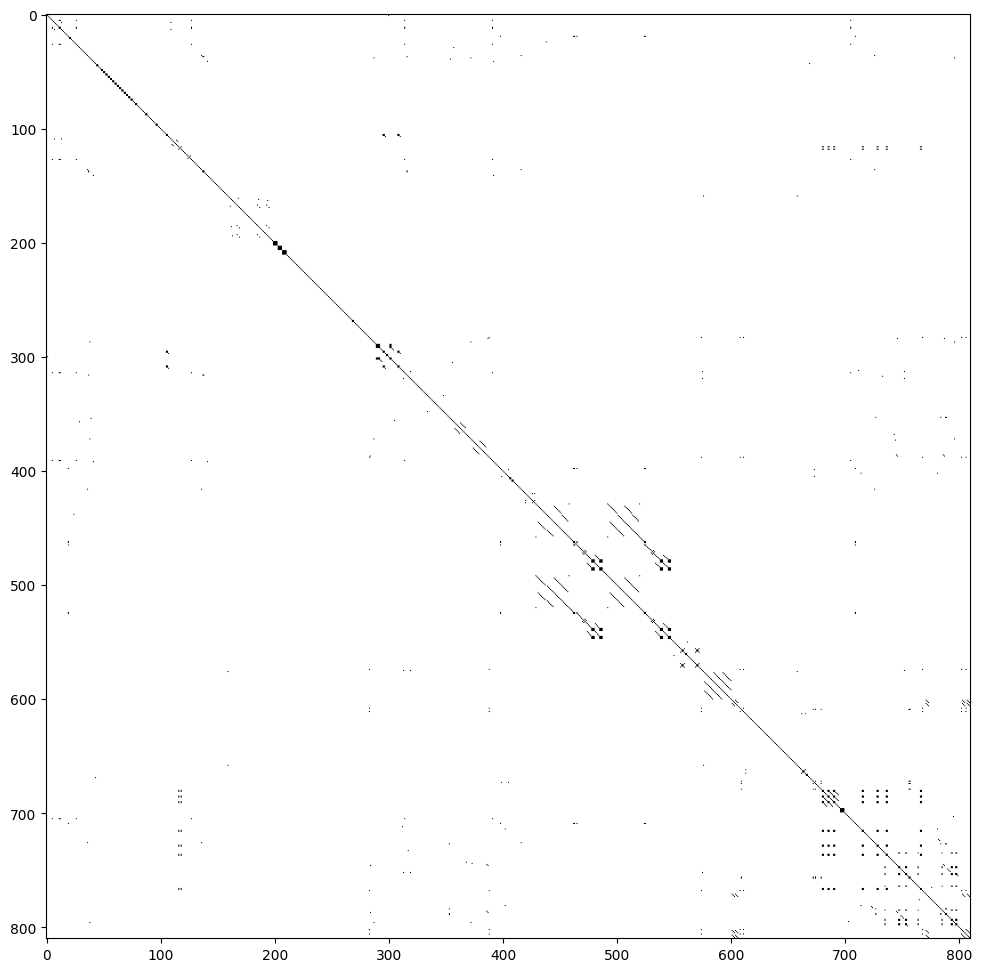

In [60]:
# parametered hooklog

matched = createDotMatrix(hl_par_list[0])

plt.figure(figsize=(12,12))
plt.imshow(matched, cmap='Greys')
plt.show()

In [61]:
# Two hooklogs

def createPairDotMatrix(h1, h2):
  n = len(h1)
  m = len(h2)

  x = h1.li
  y = h2.li

  matched = [[0 for j in range(n)] for i in range(m)]
  for i, t_api_x in enumerate(x):
    for j, t_api_y in enumerate(y):
      if h1.par ==True and h2.par == True:
        api_x = t_api_x[1] + t_api_x[2]
        api_y = t_api_y[1] + t_api_y[2]
      else:
        api_x = t_api_x[1]
        api_y = t_api_y[1]
      if api_x == api_y:
        matched[j][i] = 1.0

  return matched

class Hooklog: /content/hooklogs/2272d05b959f133bcf3e38c48ddbfcad_1472.trace.hooklog, par = True, len = 20, digit name = 2272d0-1472
class Hooklog: /content/hooklogs/8523f5ace7369187b1f55c2066a82836_1412.trace.hooklog, par = True, len = 9, digit name = 8523f5-1412


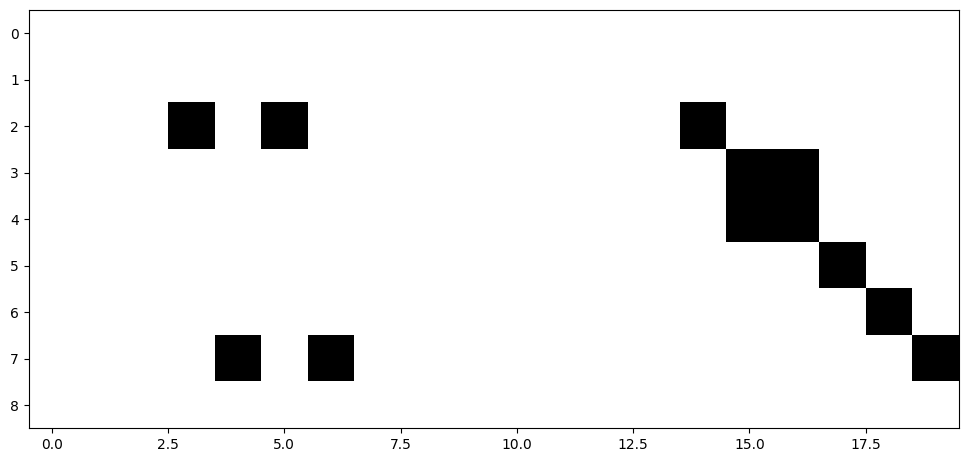

In [65]:
# two parametered hooklog

par_h1 = hl_par_list[1]
par_h2 = hl_par_list[2]
print(par_h1)
print(par_h2)

pair_matched = createPairDotMatrix(par_h1, par_h2)

plt.figure(figsize=(12,12))
plt.imshow(pair_matched, cmap='Greys')
plt.show()